# Exploring the effect of Precipitation Patterns in Long Term Landscape Evolution 

## Import declarations

In [1]:
import landlab
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FastscapeEroder, LinearDiffuser, Lithology, LithoLayers, SinkFillerBarnes
from landlab.plot import imshow_grid
import numpy as np 
import time
import matplotlib.pyplot as plt

## Initialise Grid

We initialise a grid that is 100 km x 100 km wide, in units of *metres*. The boundaries are fixed at zero at the top and bottom but left closed at the east and west. Uniform noise up to 10 metres of elevation is added at all points in the landscape to allow for channelisation.

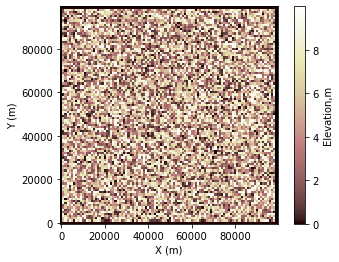

In [258]:
nx = 100 # number of grid cells (x)
ny = 100 # number of grid cells (y)
dx = 1000 # metres

grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
water_flux_in = grid.add_ones("water__unit_flux_in", at="node")
elev = grid.add_zeros('topographic__elevation',at='node')
grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

np.random.seed(1)
elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]
imshow_grid(grid,'topographic__elevation',var_name="Elevation,m")

# Orographic Precipitation 

We are going to look at different precipitation scenarios and see how landscapes evolve through time:
As a reference precipitation we are looking are the precipitation in Boulder, CO. This amounts to 0.51 m of rainfall per year on average between 1971 and 2000: https://psl.noaa.gov/boulder/Boulder.mm.precip.html. We will use this value as a rough reference for the precipitation values in our scenarios. 

* **Binary**: The simulation domain is split up into two precipitation rates.
* **Linear**: Linear gradient in precipitation, scales with row values.
* **Orographic simple**: Precipitation scales linearly with normalised elevation.
* **Orographic complex**: The precipitation pattern takes into account the orographic effect from a mountain range. In this case, we assume that the windward side is at the North of the grid and the leeward side is at the Southern part of the grid. For each timestep we calculate the maximum elevation value for each column of the grid. Values further north than the max of each column are assigned a higher precipitation rate than those south of the max value. These precipitation rates are then multiplied by the normalised elevation to capture the effects of changing relief. 

In [3]:
def calculate_index_max_elev(elevation):
    """
    Calculates the index location of the maximum value per column
    
    Parameters
    ----------
    elevation: grid with elevation values
    
    Returns
    -------
    index_max_elev_x: y axis index of the highest elevation point for each column
    index_max_elev_y: list with the column positions
    
    """
    # calculate the max elevation along the x axis nodes (need to average over y)
    reshaped_elev = elevation.reshape(100,100)

    max_elev_x = np.max(reshaped_elev, axis = 0)

    # find the y axis index of the highest elevation point for each column.
    index_max_elev_x = np.argmax(reshaped_elev,0,keepdims=True)
    index_max_elev_x = index_max_elev_x.squeeze()
    # create a list with the column positions
    index_max_elev_y = np.arange(0,100,1)
    return index_max_elev_x, index_max_elev_y

In [4]:
# convert the index into the landlab grid 
def change_origin_coords(x,y, nx, ny):
    """
    Changes the origin of the grid from numpy array (top left) to landlab grid (bottom left).
    
    Parameters
    ----------
    x: y axis index of the highest elevation point for each column
    y: list with the column positions
    nx: total number of rows
    ny: total number of columns
    
    Returns
    -------
    x_new: converted into origin bottom left - y axis index of the highest elevation point for each column
    y_new: converted into origin bottom left - list with the column positions
    
    """
    x_new = nx - x - 1
    y_new = y # this doesn't change in this case
    return x_new, y_new

def convert_coords_to_node_number(x,y, nx, ny):
    """
    Convert coordinates (rows, columns) to node number in a landlab grid.
    
    Parameters
    ----------
    x: converted into origin bottom left - y axis index of the highest elevation point for each column
    y: converted into origin bottom left - list with the column positions
    nx: total number of rows
    ny: total number of columns
    
    Returns
    -------
    node_number: landlab grid node corresponding to the x,y location given 
    
    """
    node_number = (x*ny) + (nx-y)-1 # -1 to account for starting at 0
    return node_number

In [5]:
# check the row position - this is with the values pre trnasformed
def windward_leeward_division(max_rows, max_cols, nx, ny):
    """
    Calculates the factor by which precipitation will change. Any elements smaller than
    the position of the max value of each column will have a higher precipitation change.
    
    Parameters
    ----------
    max_rows: y axis index of the highest elevation point for each column
    max_cols: list with the column positions
    nx: total number of rows
    ny: total number of columns
    
    Returns
    -------
    change_factor: array with the factor by which precipitation changes at each node
    
    """
    change_factor =  np.ones((nx, ny))
    for i in range(nx):
        change_factor[:max_rows[i],max_cols[i]]+=1
        change_factor[max_rows[i]:,max_cols[i]]+=2

    change_factor = change_factor.flatten()
    return change_factor   

In [6]:
def run_orographic_prec(elevation):
    """
    Runs all the components to calculate the change in precipitation from the elevation data.
    
    Parameters
    ----------
    elevation: grid with elevation values
    
    Returns
    -------
    change_factor: array with the factor by which precipitation changes at each node
    
    """
    index_max_elev_x, index_max_elev_y = calculate_index_max_elev(elevation)
    x_new, y_new = change_origin_coords(index_max_elev_x,index_max_elev_y, ny, ny)
    node_number = convert_coords_to_node_number(x_new,y_new, ny, ny)
    change_factor = windward_leeward_division(index_max_elev_x, index_max_elev_y, nx, ny)
    return change_factor

In [78]:
def choose_precip_pattern(i, precip_name,elevation, max_prec = 5):
    """
    Choose the type of precipitation pattern for the model run.
    
    Parameters
    ----------
    i: iteration number
    precip_name: name of precip ('binary', 'linear', 'orographic_simple', 'orographic_complex')
    elevation: grid of elevation values. 
    max_prec: max precip value for the linear precipitation.

    """
    if precip_name == 'binary':
        water_flux_in[grid.y_of_node>(ny*dx)/2]=2
    elif precip_name == 'linear':
        water_flux_in[grid.y_of_node>=0] = (max_prec * grid.y_of_node)/(ny*1000)
    elif precip_name == 'orographic_simple':
        water_flux_in[grid.y_of_node>=0] = (elevation)/np.max(elevation)
    else:
        precip_change_factor = run_orographic_prec(elevation)
        #orographic complex
        if i == 0 :
            water_flux_in[grid.y_of_node>=0] = (elevation)/np.max(elevation)
        if i%10==9:
            water_flux_in[grid.y_of_node>=0] = (elevation*precip_change_factor)/np.max(elevation)
    

# Initialise Components

### Flowrouting

First we initialise the flowrouter and a sink-filler that fills in the pits in the random topography allowing for channelisation to occur. We display the drainage area that results from these calculations below.

In [259]:
sb = SinkFillerBarnes(grid, method='D8')
sb.run_one_step()

fr = FlowAccumulator(grid, flow_director='D8')
fr.run_one_step()

### Erosion and diffusion

Next we initialise the stream power law eroder and the linear diffuser using realistic values. 

For the parameters $n$ and $m$ we use 1, and 0.5 respectively. 

For $K_{sp}$, a reasonable range appears to be $10^{-2}$ to $10^{-4}$ m/kyr. For $D_{diff}$, a reasonable range appears to be anything less than $10^{3}$ m$^2$/kyr. These ranges are broadly supported by real-life studies e.g. ([Roberts & White](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2009JB006692), [Rosenblum & Anderson](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/94JB00048)), although wider ranges have been reported (e.g. see [Campforts 2015](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/94JB00048))

Note that we add the *discharge_field* which takes into account the water flux input from precipitation.

In [260]:
n_sp = 1
m_sp = 0.5 
K_sp = 1e-3 #m/kyr 
D_diff = 1 # m^2/kyr
diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp, discharge_field='surface_water__discharge')

peclet = ((nx*dx)*K_sp)/D_diff
print("Peclet number =",peclet)

Peclet number = 100.0


#### Time-step calculations

Using these values we now calculate the appropriate timesteps so that these advective and diffusive timesteps can be performed correctly.

For the advective model, $dt < \frac{dx}{K_{sp}}$, and for the diffusive model, $dt < \frac{dx^2}{D_{diff}}$.

In [261]:
dt_max_adv = grid.dx/K_sp
dt_max_diff = (grid.dx)**2/D_diff

print("Advective stability condition: t < ",dt_max_adv, "kyr")
print("Diffusive stability condition: t < ",dt_max_diff, "kyr")

Advective stability condition: t <  1000000.0 kyr
Diffusive stability condition: t <  1000000.0 kyr


Hence, as long as our timestep is less than these timesteps the solutions should be stable. 

We run the model, using a timestep of 100 kyr for 50 Myr at a uniform uplift rate of 0.1 m/kyr. 

In [ ]:
dt = 100 # 100 kyr
uplift_rate= 0.1 # 0.1 m/kyr
runtime= 50000 # 50000 kyr = 50 Myr
n_steps = runtime//dt 
precip_type = 'linear' # choose between binary, linear, orographic_simple, orographic_complex
print("Running for", n_steps, "iterations")

start=time.time()
for i in np.arange(n_steps):
    t=i*dt
    elev[grid.core_nodes] += uplift_rate * dt
    choose_precip_pattern(i, precip_type, elev, max_prec = 5)
    fr.run_one_step()
    sp.run_one_step(dt)
    diff.run_one_step(dt)

end=time.time()
print("Time per iteration =",round((end-start)/n_steps,5),"s")
print("Total runtime =",round((end-start),3),"s")
print("Peclet number =",peclet)
fig_linear = imshow_grid(grid,'topographic__elevation',var_name="Elevation, m",output=True,cmap='gist_earth')


## Running all scenarios 


Let's initialise the starting conditions again. 
We will use a linear precipitation pattern. 


In [80]:
precip_types = ['binary', 'linear', 'orographic_simple','orographic_complex']
precip_map = []
elevation_map = []
final_states = []

for precip in precip_types:
    print("precip_type:"+  precip)

    nx = 100 # number of grid cells (x)
    ny = 100 # number of grid cells (y)
    dx = 1000 # metres
    n_sp = 1
    m_sp = 0.5 
    K_sp = 1e-3 #m/kyr 
    D_diff = 1 # m^2/kyr
    peclet = ((nx*dx)*K_sp)/D_diff

    grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
    elev = grid.add_zeros('topographic__elevation',at='node')
    water_flux_in = grid.add_ones("water__unit_flux_in", at="node")

    grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

    np.random.seed(1)
    elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]


    sb = SinkFillerBarnes(grid, method='D8')
    sb.run_one_step()
    fr = FlowAccumulator(grid, flow_director='D8')
    fr.run_one_step()
    diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
    sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp, discharge_field='surface_water__discharge')

    dt = 100 # 100 kyr
    uplift_rate= 0.1 # 0.1 m/kyr
    runtime= 50000 # 50000 kyr = 50 Myr
    n_steps = runtime//dt
    print("Running for", n_steps, "iterations")

    start=time.time()
    for i in np.arange(n_steps):
        t=i*dt
        elev[grid.core_nodes] += uplift_rate * dt
        choose_precip_pattern(i, precip, elev, max_prec = 5)
        fr.run_one_step()
        sp.run_one_step(dt)
        diff.run_one_step(dt)

    final_elev = grid.at_node['topographic__elevation']
    f_elev_pic = grid.node_vector_to_raster(final_elev)
    
    final_prec = grid.at_node['water__unit_flux_in']
    f_prec_pic = grid.node_vector_to_raster(final_prec)
    
    precip_map.append(f_prec_pic)
    elevation_map.append(f_elev_pic)
   


precip_type:half_half
Running for 500 iterations
precip_type:linear
Running for 500 iterations
precip_type:orographic_simple
Running for 500 iterations
precip_type:orographic_complex
Running for 500 iterations


## Plotting results

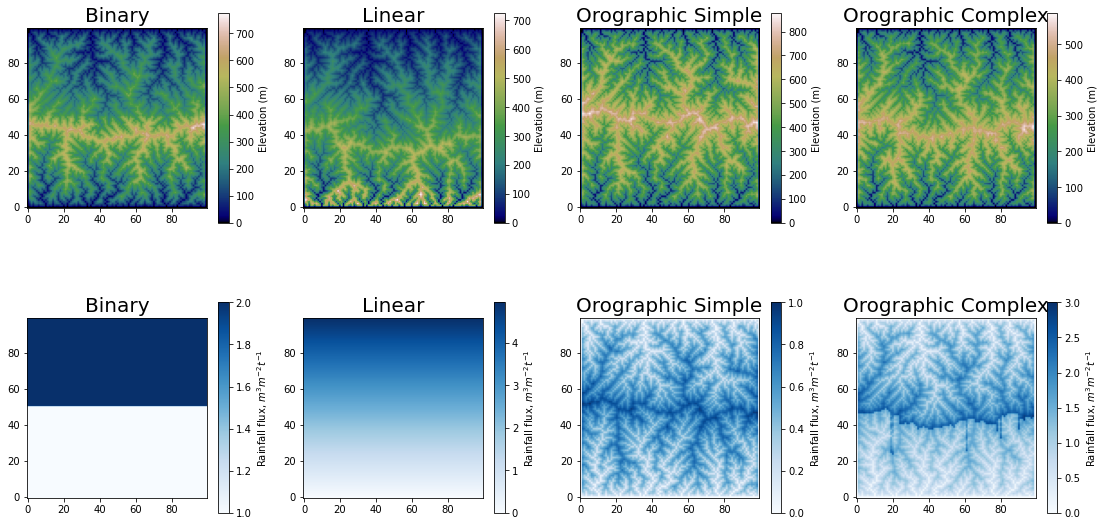

In [84]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(15.5, 8.5)

a0 = axs[0,0].imshow(elevation_map[0], origin='lower',cmap='gist_earth')
axs[0,0].set_title('Binary', fontdict={'fontsize': '20'})

a1 = axs[0, 1].imshow(elevation_map[1], origin='lower',cmap='gist_earth')
axs[0, 1].set_title('Linear', fontdict={'fontsize': '20'})

a2 = axs[0, 2].imshow(elevation_map[2], origin='lower',cmap='gist_earth')
ax0 = axs[0, 2].set_title('Orographic Simple', fontdict={'fontsize': '20'})

a3 = axs[0, 3].imshow(elevation_map[3], origin='lower',cmap='gist_earth')
axs[0, 3].set_title('Orographic Complex', fontdict={'fontsize': '20'})



b0 = axs[1, 0].imshow(precip_map[0], origin='lower',cmap='Blues')
axs[1, 0].set_title('Binary', fontdict={'fontsize': '20'})

b1 = axs[1, 1].imshow(precip_map[1], origin='lower',cmap='Blues')
axs[1, 1].set_title('Linear', fontdict={'fontsize': '20'})

b2 = axs[1, 2].imshow(precip_map[2], origin='lower',cmap='Blues')
axs[1, 2].set_title('Orographic Simple', fontdict={'fontsize': '20'})

b3 = axs[1, 3].imshow(precip_map[3], origin='lower',cmap='Blues')
axs[1, 3].set_title('Orographic Complex', fontdict={'fontsize': '20'})

cbar0 = fig.colorbar(a0, ax=axs[0,0], shrink=0.7, label = 'Elevation (m)')

cbar1 = fig.colorbar(a1, ax=axs[0,1], shrink=0.7, label = 'Elevation (m)')

cbar2 = fig.colorbar(a2, ax=axs[0,2], shrink=0.7, label = 'Elevation (m)')

cbar3 = fig.colorbar(a3, ax=axs[0,3], shrink=0.7, label = 'Elevation (m)')

cbar4 = fig.colorbar(b0, ax=axs[1,0], shrink=0.7, label = "Rainfall flux, $m^{3}m^{-2}t^{-1}$")

cbar5 = fig.colorbar(b1, ax=axs[1,1], shrink=0.7, label = "Rainfall flux, $m^{3}m^{-2}t^{-1}$")

cbar6 = fig.colorbar(b2, ax=axs[1,2], shrink=0.7, label = "Rainfall flux, $m^{3}m^{-2}t^{-1}$")

cbar7 = fig.colorbar(b3, ax=axs[1,3], shrink=0.7, label = "Rainfall flux, $m^{3}m^{-2}t^{-1}$")

plt.tight_layout()
plt.savefig('precipitation_patterns.png')